# Model Selection

### Load Libraries

In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [60]:
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

### Load Data

In [61]:
path = os.getcwd()
path = path.replace('modeling', 'resources')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = os.path.join(path, file)
data = pd.read_csv(csv_path)

### Data Preperation

In [62]:
data['SeniorCitizen']=data['SeniorCitizen'].map({0:'No', 1:'Yes'})
data['TotalCharges']=pd.to_numeric(data.TotalCharges, errors='coerce')
data.drop(data[data.TotalCharges.isna()].index, axis=0, inplace=True)
data.drop('customerID', axis=1, inplace=True)
data.reset_index()

,index,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,2,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,3,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,4,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7028,7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7029,7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


### Feature Engineering

In [63]:
X = data.drop(['Churn', 'PhoneService'], axis=1)
y = data['Churn'].replace({"Yes":1, "No":0})

internet_addon_services = X.columns[(X == 'No internet service').any()].to_list()
for col in internet_addon_services:
    X[col] = X[col].replace({'No internet service':'No'})

In [64]:
cat_columns = X.select_dtypes(include='object').columns.to_list()
num_columns = X.select_dtypes(include='number').columns.to_list()

cat_columns1 = X.columns[(X == 'No').any()].to_list() #All these features have a 'No' value which we can target and make 0
cat_columns2 = list(set(X.select_dtypes(include='object').columns)-set(cat_columns1))  # We can drop the first column for these features

In [65]:
# Train - Validation - Test Split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=1)

In [66]:
drop_no = ['No'] * len(cat_columns1)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns1), # One-Hot Encode and drop 'No' value features 
                ('OH2', OneHotEncoder(sparse_output=False, drop='first'), cat_columns2), # One-Hot Encode and drop first column
                ('scaler', MinMaxScaler(), num_columns), # Scale Numerical columns to lie between 0 and 1
                ]

preprocessor = ColumnTransformer(transformer)

In [67]:
# Transform categorical features
X_train_ppd = preprocessor.fit_transform(X_train)
X_val_ppd = preprocessor.transform(X_val)
X_test_ppd = preprocessor.transform(X_test)

feature_names = []
for name, trans, column in preprocessor.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        feature_names.extend(trans.get_feature_names_out(column))
    else:
        feature_names.extend(column)

X_train_ppd = pd.DataFrame(X_train_ppd, columns=feature_names)
X_val_ppd = pd.DataFrame(X_val_ppd, columns=feature_names)
X_test_ppd = pd.DataFrame(X_test_ppd, columns=feature_names)

In [68]:
# Oversampling
smote = SMOTE(k_neighbors=7, sampling_strategy=0.45, random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ppd, y_train)

In [69]:
X_train_resampled.shape

(4451, 23)

In [70]:
X_train_resampled.columns

Index(['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'PaperlessBilling_Yes', 'gender_Male', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [71]:
X_train_resampled.describe()

,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,...,PaperlessBilling_Yes,gender_Male,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
count,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,...,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00,4451.00
mean,0.17,0.47,0.29,0.09,0.43,0.34,0.45,0.28,0.34,0.34,...,0.61,0.51,0.20,0.23,0.22,0.35,0.23,0.43,0.47,0.26
std,0.37,0.50,0.45,0.29,0.50,0.48,0.50,0.45,0.47,0.47,...,0.49,0.50,0.40,0.42,0.41,0.48,0.42,0.34,0.30,0.26
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.22,0.04
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.37,0.52,0.16
75%,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.75,0.71,0.42
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Model Selection

We can use Lazy Predict to get a base idea of the models that we should test

In [72]:
from lazypredict.Supervised import LazyClassifier
lz_clf = LazyClassifier()

models, predictions = lz_clf.fit(X_train_resampled, X_val_ppd, y_train_resampled, y_val)

100%|██████████| 29/29 [00:05<00:00,  5.29it/s]


In [73]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.76,0.76,0.76,0.77,0.01
LinearDiscriminantAnalysis,0.81,0.75,0.75,0.81,0.12
LinearSVC,0.81,0.75,0.75,0.81,0.32
NearestCentroid,0.74,0.75,0.75,0.75,0.01
LogisticRegression,0.81,0.75,0.75,0.81,0.04
GaussianNB,0.75,0.75,0.75,0.77,0.01
CalibratedClassifierCV,0.81,0.74,0.74,0.81,1.10
Perceptron,0.75,0.74,0.74,0.76,0.01
BernoulliNB,0.78,0.74,0.74,0.79,0.01


In [74]:
models.sort_values(by='F1 Score', ascending=False)[:10]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.81,0.75,0.75,0.81,0.32
CalibratedClassifierCV,0.81,0.74,0.74,0.81,1.10
SVC,0.81,0.73,0.73,0.81,0.46
LogisticRegression,0.81,0.75,0.75,0.81,0.04
LinearDiscriminantAnalysis,0.81,0.75,0.75,0.81,0.12
RidgeClassifierCV,0.80,0.74,0.74,0.80,0.27
RidgeClassifier,0.80,0.74,0.74,0.80,0.01
NuSVC,0.81,0.72,0.72,0.80,0.53
AdaBoostClassifier,0.80,0.73,0.73,0.80,0.14


In [75]:
# ROC AUC Plot
def roc_auc_plot(y_test, y_proba):


    plt.figure(figsize=(4, 4))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
        
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Charactristics")
    plt.legend(loc="lower right")

    #Diagonal Line
    plt.plot([0,1], [0,1], color = 'navy', lw=2, linestyle='--')

    plt.show()

LinearSVC - Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.75


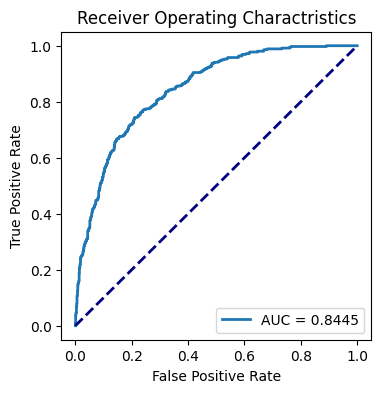

CalibratedClassifierCV - Accuracy: 0.81, Balanced Accuracy: 0.74, F1 Score: 0.75


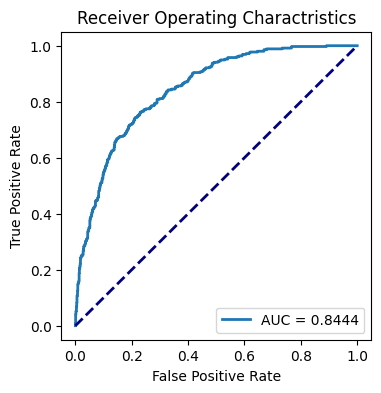

SVC - Accuracy: 0.81, Balanced Accuracy: 0.73, F1 Score: 0.74


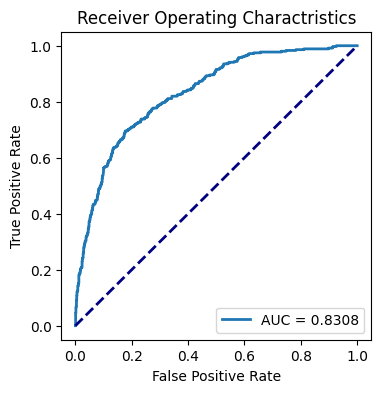

LogisticRegression - Accuracy: 0.81, Balanced Accuracy: 0.74, F1 Score: 0.75


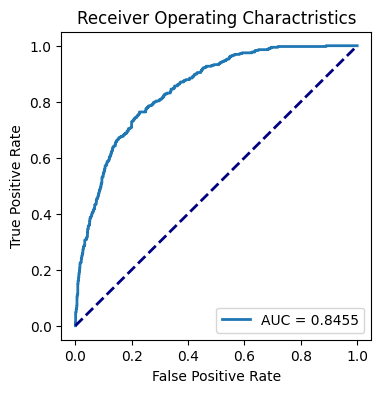

LinearDiscriminantAnalysis - Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.75


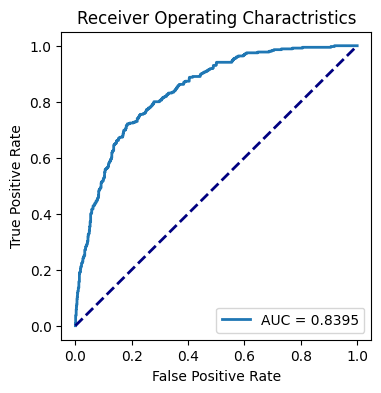

RidgeClassifierCV - Accuracy: 0.80, Balanced Accuracy: 0.74, F1 Score: 0.74


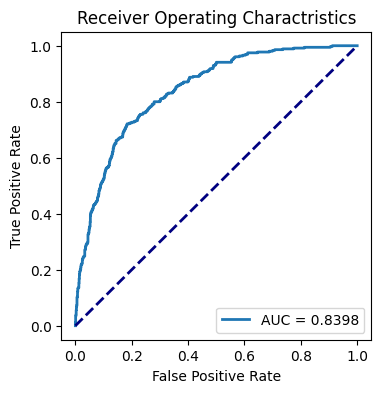

RidgeClassifier - Accuracy: 0.80, Balanced Accuracy: 0.74, F1 Score: 0.74


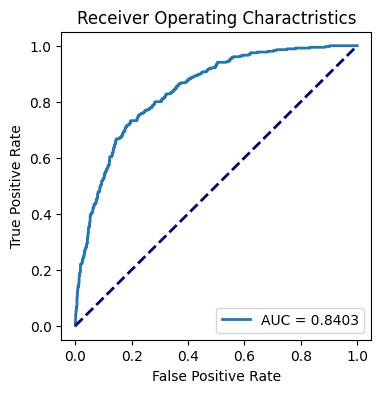

NuSVC - Accuracy: 0.81, Balanced Accuracy: 0.72, F1 Score: 0.73


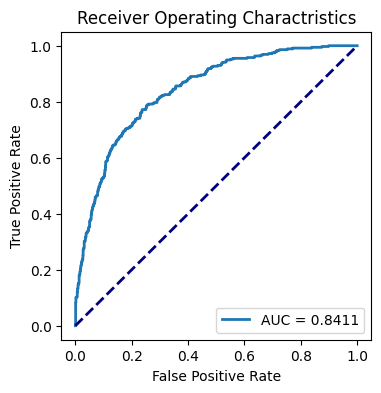

AdaBoostClassifier - Accuracy: 0.80, Balanced Accuracy: 0.73, F1 Score: 0.73


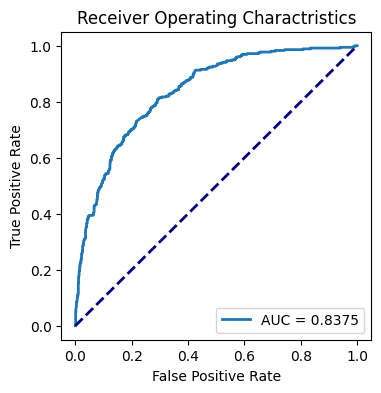

LGBMClassifier - Accuracy: 0.80, Balanced Accuracy: 0.72, F1 Score: 0.73


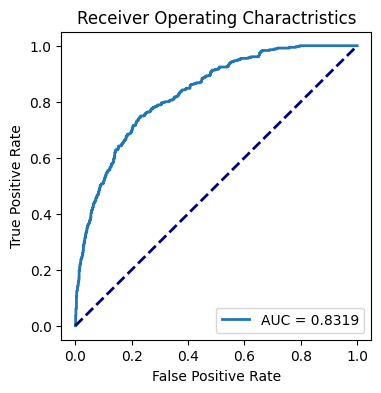

RandomForestClassifier - Accuracy: 0.80, Balanced Accuracy: 0.70, F1 Score: 0.71


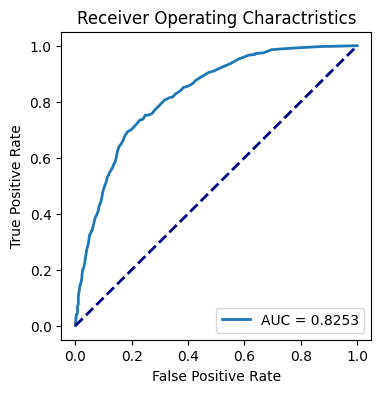

In [76]:
# Importing necessary libraries

from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score


# List of models to check
models = [
    ('LinearSVC', LinearSVC(random_state=1)),
    ('CalibratedClassifierCV', CalibratedClassifierCV()),
    ('SVC', SVC(probability=True, random_state=1)),
    ('LogisticRegression', LogisticRegression(random_state=1)),
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
    ('RidgeClassifierCV', RidgeClassifierCV()),
    ('RidgeClassifier', RidgeClassifier()),
    ('NuSVC', NuSVC(probability=True, random_state=1)),
    ('AdaBoostClassifier', AdaBoostClassifier(random_state=1)),
    ('LGBMClassifier', LGBMClassifier(random_state=1)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=1))
]

# Iterating through each model, training, predicting and calculating metrics
for name, model in models:
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val_ppd)
    
    # Calculate Metrics
    acc = accuracy_score(y_val, y_pred)
    bal_acc = balanced_accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    # Printing metrics
    print(f"{name} - Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

    # Check if the model has the predict_proba method
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_val_ppd)[:, 1]
    # Otherwise, use decision_function for LinearSVC
    else:
        y_proba = model.decision_function(X_val_ppd)

    roc_auc_plot(y_val, y_proba)



#### LinearSVC vs LogisticRegression

##### LogisticRegression

/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9

Best Parameter:  {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.75


/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


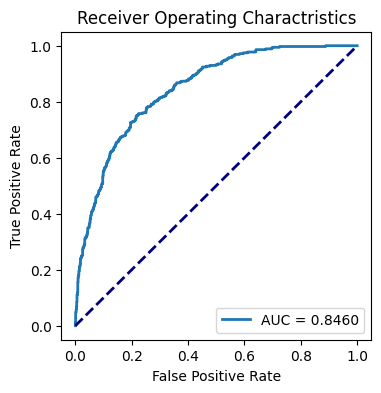

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.62      0.62      0.62       355

    accuracy                           0.81      1407
   macro avg       0.75      0.75      0.75      1407
weighted avg       0.81      0.81      0.81      1407

[[919 133]
 [135 220]]


In [77]:
from sklearn.model_selection import GridSearchCV

model1 = LogisticRegression(random_state=1)

param_grid1 = {
    'penalty' : ['l1', 'l2', 'elasticinet', 'None'],
    'C' : [0.1, 1, 10, 100],
    'class_weight' : [None, 'balanced'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [100, 500, 1000, 5000]
}

grid_search1 = GridSearchCV(estimator=model1, param_grid=param_grid1, cv=5, scoring='f1_macro', n_jobs=-1)

grid_search1.fit(X_train_resampled, y_train_resampled)

print("Best Parameter: ", grid_search1.best_params_)

best_estimator1 = grid_search1.best_estimator_

y_pred = best_estimator1.predict(X_val_ppd)

# Calculate Metrics
acc = accuracy_score(y_val, y_pred)
bal_acc = balanced_accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(best_estimator1, 'predict_proba'):
    y_proba = best_estimator1.predict_proba(X_val_ppd)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = best_estimator1.decision_function(X_val_ppd)

roc_auc_plot(y_val, y_proba)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Best Parameter:  {'C': 1, 'max_iter': 30, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.75


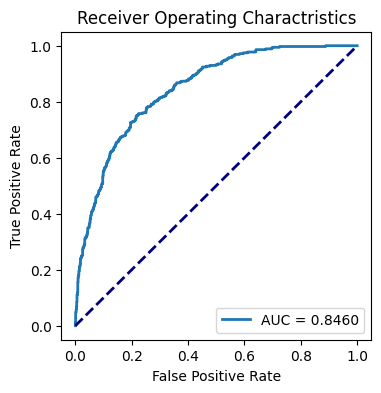

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.62      0.62      0.62       355

    accuracy                           0.81      1407
   macro avg       0.75      0.75      0.75      1407
weighted avg       0.81      0.81      0.81      1407

[[919 133]
 [135 220]]


In [78]:
model1 = LogisticRegression(random_state=1)

param_grid1 = {
    'penalty' : ['l1'],
    'C' : [0.3, 1, 3],
    'solver' : ['liblinear'],
    'max_iter' : [30, 50, 75, 100, 125]
}

grid_search1 = GridSearchCV(estimator=model1, param_grid=param_grid1, cv=5, scoring='f1_macro', n_jobs=-1)

grid_search1.fit(X_train_resampled, y_train_resampled)

print("Best Parameter: ", grid_search1.best_params_)

best_estimator1 = grid_search1.best_estimator_

y_pred = best_estimator1.predict(X_val_ppd)

# Calculate Metrics
acc = accuracy_score(y_val, y_pred)
bal_acc = balanced_accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(best_estimator1, 'predict_proba'):
    y_proba = best_estimator1.predict_proba(X_val_ppd)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = best_estimator1.decision_function(X_val_ppd)

roc_auc_plot(y_val, y_proba)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

##### LinearSVC

/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/s

Best Parameter:  {'C': 1, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 100, 'penalty': 'l1'}
Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.74


/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


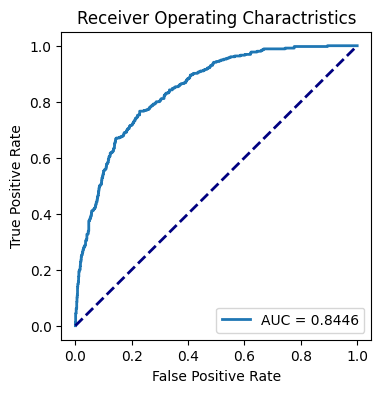

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.62      0.62      0.62       355

    accuracy                           0.81      1407
   macro avg       0.74      0.75      0.74      1407
weighted avg       0.81      0.81      0.81      1407

[[916 136]
 [135 220]]


In [79]:
model2 = LinearSVC(random_state=1)

param_grid2 = {
    'penalty' : ['l1', 'l2', 'None'],
    'C' : [0.1, 1, 3, 10, 100],
    'class_weight' : [None, 'balanced'],
    'loss' : ['hinge', 'squared_hinge'],
    'dual' : [True, False],
    'max_iter' : [100, 500, 1000, 2500, 5000]
}

grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid2, cv=5, scoring='f1_macro', n_jobs=-1)

grid_search2.fit(X_train_resampled, y_train_resampled)

print("Best Parameter: ", grid_search2.best_params_)

best_estimator2 = grid_search2.best_estimator_

y_pred = best_estimator2.predict(X_val_ppd)

# Calculate Metrics
acc = accuracy_score(y_val, y_pred)
bal_acc = balanced_accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(best_estimator2, 'predict_proba'):
    y_proba = best_estimator2.predict_proba(X_val_ppd)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = best_estimator2.decision_function(X_val_ppd)

roc_auc_plot(y_val, y_proba)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameter:  {'C': 1, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 100, 'penalty': 'l1'}
Accuracy: 0.81, Balanced Accuracy: 0.75, F1 Score: 0.74


/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/georgethomas/Documents/ML/JUN_23/telco-customer-churn/.venv/lib/python3.9/site-packages/sklearn/s

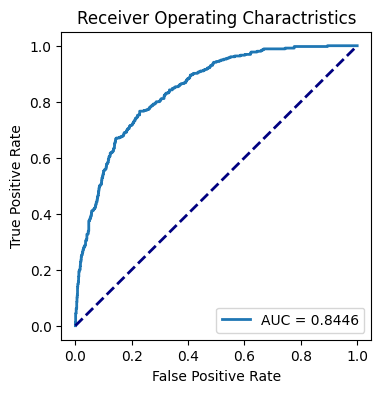

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1052
           1       0.62      0.62      0.62       355

    accuracy                           0.81      1407
   macro avg       0.74      0.75      0.74      1407
weighted avg       0.81      0.81      0.81      1407

[[916 136]
 [135 220]]


In [80]:
model2 = LinearSVC(random_state=1)

param_grid2 = {
    'penalty' : ['l1'],
    'C' : [1],
    'class_weight' : [None],
    'loss' : ['squared_hinge'],
    'dual' : [False],
    'max_iter' : [75, 100, 125]
}

grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid2, cv=5, scoring='f1_macro', n_jobs=-1)

grid_search2.fit(X_train_resampled, y_train_resampled)

print("Best Parameter: ", grid_search2.best_params_)

best_estimator2 = grid_search2.best_estimator_

y_pred = best_estimator2.predict(X_val_ppd)

# Calculate Metrics
acc = accuracy_score(y_val, y_pred)
bal_acc = balanced_accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(best_estimator2, 'predict_proba'):
    y_proba = best_estimator2.predict_proba(X_val_ppd)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = best_estimator2.decision_function(X_val_ppd)

roc_auc_plot(y_val, y_proba)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


Based on the above information we can select Logistic Regression as our prediction model.

### Evauation on Test set

Accuracy: 0.80, Balanced Accuracy: 0.74, F1 Score: 0.74


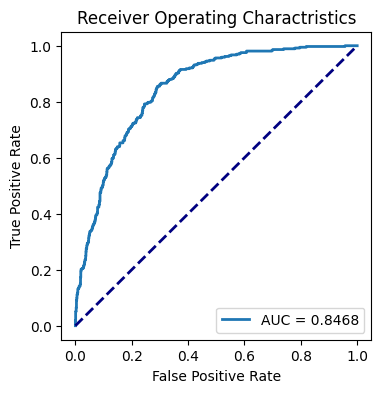

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1041
           1       0.61      0.61      0.61       366

    accuracy                           0.80      1407
   macro avg       0.74      0.74      0.74      1407
weighted avg       0.80      0.80      0.80      1407

[[898 143]
 [142 224]]


In [82]:
model = LogisticRegression(C= 1, max_iter=30, penalty='l1', solver='liblinear', random_state=1)

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_ppd)

# Calculate Metrics
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# Printing metrics
print(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}, F1 Score: {f1:.2f}")

# Check if the model has the predict_proba method
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test_ppd)[:, 1]
# Otherwise, use decision_function for LinearSVC
else:
    y_proba = model.decision_function(X_test_ppd)

roc_auc_plot(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


#### Model Selection Summary

Having tested various models, we have selected our prediction model as `LogisticRegression`, with the following hyperparameters:
- `C`= 1, 
- `max_iter`=30, 
- `penalty`='l1', 
- `solver`='liblinear'


We shall now proceed to Feature Selection